## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, dct, idct
from scipy.io import wavfile # get the api
import numpy as np
from IPython.display import Audio
import math

fs, audio = wavfile.read('clip.wav')
Audio('clip.wav')

## Audio Input Information

In [4]:
print(f"Audio Type: {audio.dtype}")
print(f"Samples = {audio.shape[0]}   Channels = {audio.shape[1]}") #output=(samples,channels)
print(f"Sampling frequency = {fs} Hz")

# audio = np.mean(audio, axis=1).astype(numpy.int16) #mean of 2-channel audio or use audio.T[0] to select channel
# audio = audio / (2**15)
audio = audio.T[0]
samples = audio.shape[0]
L = (samples / fs)*1000
print(f'Audio length: {L:.0f} mili-seconds')

f, ax = plt.subplots()
ax.plot((np.arange(samples) / fs)*1000, audio)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Amplitude');

Audio Type: int16
Samples = 9216   Channels = 2
Sampling frequency = 44100 Hz
Audio length: 209 mili-seconds


In [5]:
def Edft(x,L,k): #calculating error dft for x
    y = fft(x)
    N = len(y)
    a = int((N+1-L)/2)
    b = int((N-1+L)/2)
    for i in range(a,b+1):
        y[i] = 0
    x_m = ifft(y)
    
    if k==1:
        return ((x - x_m) ** 2).mean(axis=0)
    else:
        return x_m

In [6]:
def Edct(x,L,k): #calculating error dct for x
    y = dct(x)
    N = len(y)
    for i in range(N-L,N):
        y[i] = 0
    x_m = idct(y)/(2*len(x))

    if k==1:
        return ((x - x_m) ** 2).mean(axis=0)
    else:
        return x_m

In [7]:
h2 = np.array([[1,1],[1,-1]])
def haar_mat(n):
    n = int(n)
    if n == 1:
        return h2
    else:
        a = np.kron(haar_mat(n-1),[1,1])
        b = np.kron(np.identity(int(math.pow(2,n-1)))*math.pow(2,(n-1)/2.0),[1,-1])
        return np.concatenate((a,b),axis=0)

def haar(x):
    return np.matmul(haar_mat(math.log(len(x),2)),np.transpose(x))

def ihaar(y): #calculating inverse haar for x
    n = int(math.log(len(y),2))
    N = len(y)
    hn = haar_mat(n)
    return np.matmul(np.transpose(hn)/N,np.transpose(y))

def Ehaar(x,L,k): #calculating error for haar transform
    y = haar(x)
    N = len(y)
    for i in range(N-L,N):
        y[i] = 0
    x_m = ihaar(y)

    if k==1:
        return ((x - x_m) ** 2).mean(axis=0)
    else:
        return x_m
    

# print(haar_mat(math.log(len(audio),2)).shape)
# print(math.log(len(audio),2))

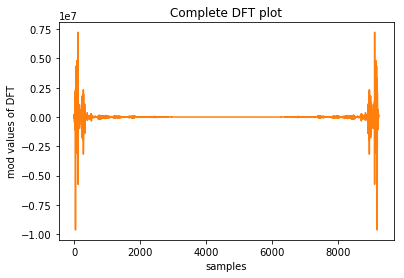

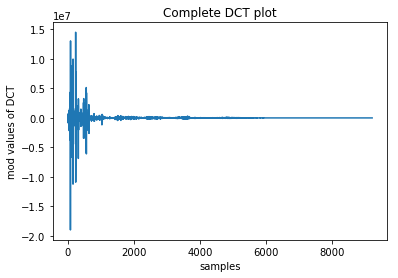

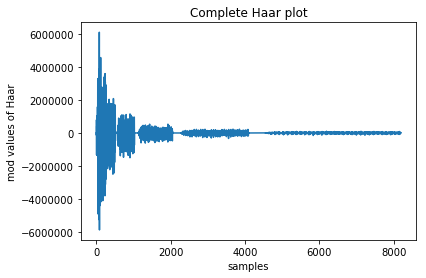

In [8]:
n = len(audio)
dft = fft(audio).real

plt.plot(dft)
plt.title('Complete DFT plot')
plt.ylabel('mod values of DFT')
plt.xlabel('samples')
plt.show()

dct_audio = dct(audio)

plt.plot(dct_audio)
plt.title('Complete DCT plot')
plt.ylabel('mod values of DCT')
plt.xlabel('samples')
plt.show()

haar_audio = haar(audio[0:8192])

plt.plot(haar_audio)
plt.title('Complete Haar plot')
plt.ylabel('mod values of Haar')
plt.xlabel('samples')
plt.show()

In [9]:
edft = [0.]*len(audio)
edct = [0.]*len(audio)
ehaar = [0.]*len(audio)

for L in range(len(audio)):
    edft[L] = Edft(audio,L,1)
    edct[L] = Edct(audio,L,1)
    ehaar[L] = Edct(audio[0:8192],L,1)

In [10]:
# Comparison
fig, ax = plt.subplots()
ax.plot(edft, 'k:', label='DFT') 
ax.plot(edct,'k--', label = 'DCT') 
ax.plot(ehaar, 'k', label='HAAR')
ax.grid()
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')

C:\Users\Rohan Gupta\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [12]:
a = Edft(audio,len(audio),0).real
wavfile.write('out/out_dft.wav', fs, a)
wavfile.write('out/out_dct.wav', fs, Edct(audio,len(audio),0))
# wavfile.write('out/out.wav', fs, Ehaar(audio,len(audio),0))